In [1]:
import torch
import os

class configuration:
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.num_worker = os.cpu_count()
        self.train_folder = "train"
        self.test_folder = "test"
        self.num_classes = os.listdir(self.train_folder)
        self.seed = 69
conf = configuration()

In [2]:
import glob
import random

random.seed(69)

test_images = glob.glob(r"test/**/**")
train_images  = glob.glob(r"train/**/**")
random.shuffle(test_images)
random.shuffle(train_images)

train_labels = [image.split("\\")[-2] for image in train_images]
test_labels = [image.split("\\")[-2] for image in test_images]

print(f"len of train images {len(train_images)}")
print(f"len of train lebel {len(train_labels)}")

print(f"len of test images {len(test_images)}")
print(f"len of test lebel {len(test_labels)}")

len of train images 14034
len of train lebel 14034
len of test images 3000
len of test lebel 3000


In [3]:
import pandas as pd

train_df = pd.DataFrame({"images":train_images , "labels": train_labels})
test_df = pd.DataFrame({"images":test_images , "labels": test_labels})


C:\Users\mahes\AppData\Local\Temp\ipykernel_31716\3288911983.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
train_df

,images,labels
0,train\street\15644.jpg,street
1,train\mountain\4155.jpg,mountain
2,train\forest\11659.jpg,forest
3,train\buildings\2954.jpg,buildings
4,train\glacier\348.jpg,glacier
...,...,...
14029,train\glacier\1044.jpg,glacier
14030,train\mountain\5234.jpg,mountain
14031,train\street\5760.jpg,street
14032,train\sea\4403.jpg,sea


In [5]:
test_df

,images,labels
0,test\glacier\24049.jpg,glacier
1,test\glacier\23762.jpg,glacier
2,test\buildings\20858.jpg,buildings
3,test\glacier\22625.jpg,glacier
4,test\street\23183.jpg,street
...,...,...
2995,test\buildings\22637.jpg,buildings
2996,test\forest\22416.jpg,forest
2997,test\buildings\23825.jpg,buildings
2998,test\buildings\21505.jpg,buildings


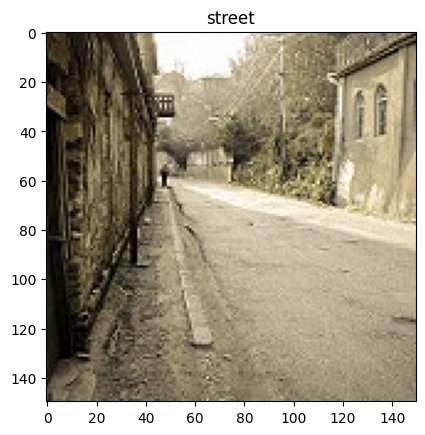

In [6]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = Image.open(test_df["images"].iloc[100])
label = test_df["labels"].iloc[100]
plt.imshow(img)
plt.title(label)
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
from PIL import Image
from torch.utils.data import Dataset , DataLoader

class MyDataset(torch.utils.data.Dataset):
    """Some Information about MyDataset"""
    def __init__(self , df , transform):
        super(MyDataset, self).__init__()
        self.df = df
        self.labels = {key:value for value , key in enumerate(os.listdir("train"))}
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.df["images"].iloc[index]
        img = Image.open(image_path)
        img = self.transform(img)
        
        label = self.df["labels"].iloc[index]
        return img , self.labels[label]

    def __len__(self):
        return len(self.df)

In [9]:
from torchvision.transforms import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(std=std , mean=mean)
])

train_dataset = MyDataset(train_df , transform)
test_dataset = MyDataset(train_df , transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1179)
tensor(2.6400)


Text(0.5, 1.0, '5')

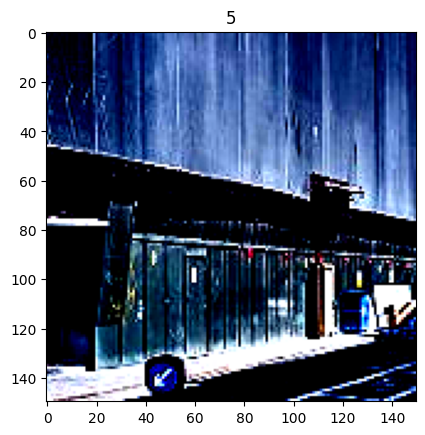

In [10]:
x , y = train_dataset[0]
plt.imshow(np.transpose(x , (1,2,0)))
print(x.min())
print(x.max())
plt.title(y)

In [11]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True , num_workers=0)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False , num_workers=0)

In [12]:
import torch.nn as nn
import torchvision.models as models

class MyModule(nn.Module):
    """Some Information about MyModule"""
    def __init__(self , num_classes):
        super(MyModule, self).__init__()
        self.efficientnet_b3 = models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT')  # Load EfficientNet-B3 without pretrained weights
        # self.features = nn.Sequential(*list(self.efficientnet_b3.children())[:-1])  # Remove the last fully connected layer
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000 , num_classes)
        )

    def forward(self, x):
        x = self.efficientnet_b3(x)
        x = self.seq(x)
        return x


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
model = MyModule(6).to(device)

In [15]:
model(torch.randn(1,3,150,150).to(device))

tensor([[-0.0737,  0.4441, -0.0795,  0.2016,  0.1372,  0.1740]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
import sys

def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10):
    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            _, predicted = probs.max(1)
            correct_train += (predicted == labels).sum()
            total_train += labels.size(0)

            sys.stdout.write(
                f"\r[Epoch {epoch + 1}/{num_epochs}] [Batch {batch_idx + 1}/{len(train_loader)}] "
                f"[Train Loss: {running_loss / (batch_idx + 1):.4f}, Train Acc: {100.0 * correct_train / total_train:.2f}%]"
            )
            sys.stdout.flush()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs , labels = inputs.to(device) , labels.to(device)
                
                outputs = model(inputs)
                
                loss = loss_fn(outputs , labels)
                val_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                _ , predicted = probs.max(1)
                
                correct_val += (predicted == labels).sum()
                total_val += labels.size(0)
                
        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        
        print(
            f"\nEpoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracy:.4f}, "
            f"Val Acc: {val_accuracy:.4f}"
        )

    session = {
        "training_losses":train_losses,
        "train_accs":train_accs,
        "val_losses":val_losses,
        "val_accs":val_accs
    }
    
    return session


In [18]:
session = train(model, train_loader, test_loader, loss_fn, optimizer,device, num_epochs=10)

[Epoch 1/10] [Batch 439/439] [Train Loss: 0.5013, Train Acc: 85.34%]
Epoch [1/10], Train Loss: 0.5013, Val Loss: 0.1500, Train Acc: 0.8534, Val Acc: 0.9486
[Epoch 2/10] [Batch 439/439] [Train Loss: 0.2889, Train Acc: 90.61%]
Epoch [2/10], Train Loss: 0.2889, Val Loss: 0.1383, Train Acc: 0.9061, Val Acc: 0.9552
[Epoch 3/10] [Batch 439/439] [Train Loss: 0.2156, Train Acc: 93.00%]
Epoch [3/10], Train Loss: 0.2156, Val Loss: 0.0763, Train Acc: 0.9300, Val Acc: 0.9775
[Epoch 4/10] [Batch 439/439] [Train Loss: 0.2143, Train Acc: 93.12%]
Epoch [4/10], Train Loss: 0.2143, Val Loss: 0.1004, Train Acc: 0.9312, Val Acc: 0.9679
[Epoch 5/10] [Batch 439/439] [Train Loss: 0.1696, Train Acc: 94.51%]
Epoch [5/10], Train Loss: 0.1696, Val Loss: 0.0678, Train Acc: 0.9451, Val Acc: 0.9776
[Epoch 6/10] [Batch 439/439] [Train Loss: 0.1747, Train Acc: 94.39%]
Epoch [6/10], Train Loss: 0.1747, Val Loss: 0.0500, Train Acc: 0.9439, Val Acc: 0.9840
[Epoch 7/10] [Batch 439/439] [Train Loss: 0.1464, Train Acc: 95.

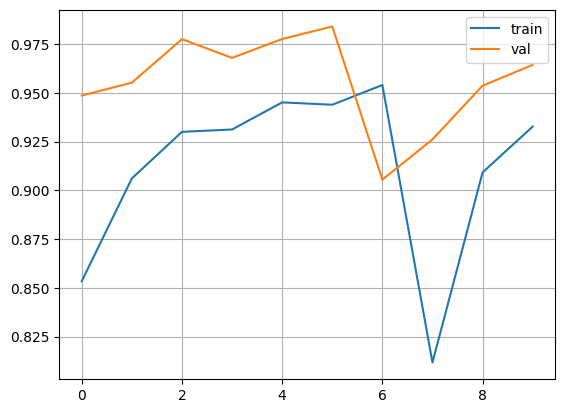

In [41]:
import matplotlib.pyplot as plt 

train_accs = session["train_accs"]
train_accs = [train_accs[i].item() for i in range(len(train_accs))]
plt.plot(train_accs, label = "train")
val_accs = session["val_accs"]
val_accs = [val_accs[i].item() for i in range(len(val_accs))]
plt.plot(val_accs , label = "val")

plt.legend()
plt.grid(True)
plt.show()

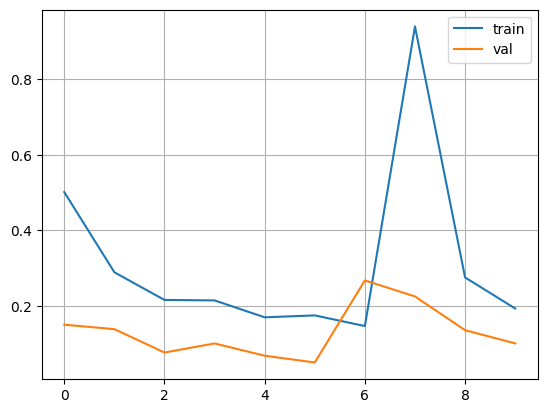

In [44]:
import matplotlib.pyplot as plt 

train_losses = session["training_losses"]
# train_losses = [train_losses[i].item() for i in range(len(train_losses))]
plt.plot(train_losses, label = "train")
val_losses = session["val_losses"]
# val_losses = [val_losses[i].item() for i in range(len(val_losses))]
plt.plot(val_losses , label = "val")

plt.legend()
plt.grid(True)
plt.show()

In [48]:
classes = os.listdir("train")

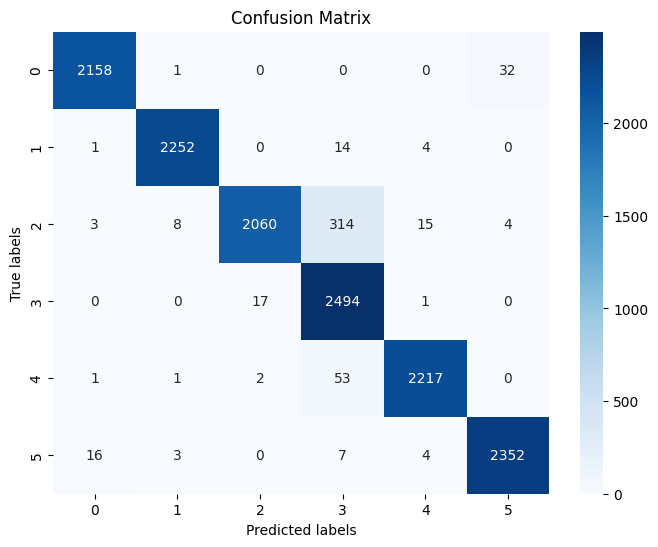

In [47]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming device and classes are defined correctly

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming model and test_loader are defined correctly

# Evaluate the model
evaluate_model(model, test_loader)


In [50]:
torch.save(model.state_dict(), 'landscapeDetector.pth')


In [51]:
import cv2
import torch
import numpy as np
from torchvision import transforms

# Define mean and standard deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to preprocess the image for model input
def preprocess_image(image):
    # Resize the image to match the input size of the model (64x64)
    resized_image = cv2.resize(image, (150, 150))
    # Convert the image to the format expected by PyTorch (RGB and float32)
    processed_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    # Normalize the image using the same mean and standard deviation as used during training
    processed_image = (processed_image - mean) / std
    # Convert the image to a PyTorch tensor and ensure it's of type float32
    tensor_image = torch.tensor(processed_image, dtype=torch.float32).permute(2, 0, 1)
    return tensor_image


# Function to predict label for a frame
def predict_frame_label(model, frame):
    # Preprocess the frame
    processed_frame = preprocess_image(frame)
    # Move the processed frame to the same device as the model
    processed_frame = processed_frame.to(device)
    # Perform inference
    output = model(processed_frame.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    probabilities = torch.softmax(output, dim=1)
    return predicted.item(), probabilities[0][predicted.item()].item()

# Load the model
loaded_model = MyModule(6).to(device)
loaded_model.load_state_dict(torch.load('landscapeDetector.pth'))
loaded_model.eval()

# Open the webcam
cap = cv2.VideoCapture(0)

# Loop to capture frames from the webcam
while(cap.isOpened()):
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform prediction on the frame
    predicted_label, probability = predict_frame_label(loaded_model, frame)
    
    # Print the predicted label and its probability on the frame
    label_text = f"Predicted Label: {predicted_label}, Probability: {probability:.2f}"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the frame
    cv2.imshow('Webcam', frame)
    
    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close any open windows
cap.release()
cv2.destroyAllWindows()
